In [2]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np 
import pyrotd

%matplotlib inline

Create a function for loading AT2 formatted time series.

In [3]:
def load_at2(fpath):
    with open(fpath) as fp:
        for _ in range(3):
            next(fp)
        line = next(fp)
        time_step = float(line[17:25])
        accels = np.array([p for l in fp for p in l.split()]).astype(float)
    return time_step, accels

Load the a pair of rotated time series in the PEER AT2 format.

In [4]:
fnames = ['RSN8883_14383980_13849360.AT2', 'RSN8883_14383980_13849090.AT2']
time_series = []
for fname in fnames:
    m = re.search(r'(\d+)(\d{3}).AT2', fname)
    name = '-'.join(m.groups())

    time_step, accels = load_at2(os.path.join('test_data', fname))
    time_series.append({
        'fname': fname,
        'name': name,
        'time_step': time_step,
        'accels': accels,
    })

Compute the response spectra for the individual components

In [5]:
osc_damping = 0.05
osc_freqs = np.logspace(-1, 2, 91)

for ts in time_series:
    ts['spec_accels'] = pyrotd.calc_spec_accels(
        ts['time_step'], ts['accels'], osc_freqs, osc_damping
    ).spec_accel

Plot the response spectra for the two components.

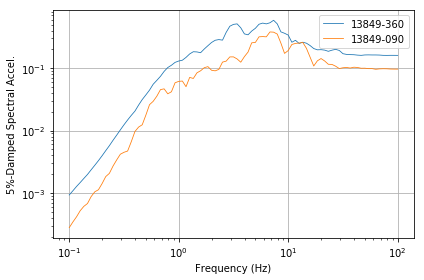

In [6]:
fig, ax = plt.subplots()

for ts in time_series:
    ax.plot(osc_freqs, ts['spec_accels'], linewidth=0.8, label=ts['name'])
    
ax.set(
    xlabel='Frequency (Hz)', xscale='log', alpha=0.8,
    ylabel='5%-Damped Spectral Accel.', yscale='log',
)
ax.legend()
ax.grid()
fig.tight_layout()

Compute the rotated response spectra by passing both time series, along with the percentiles of interest.

In [7]:
rotated_resp = pyrotd.calc_rotated_spec_accels(
    time_series[0]['time_step'], 
    time_series[0]['accels'], time_series[1]['accels'],
    osc_freqs, osc_damping, percentiles=[0, 50, 100],
)

Plot the results rotated spectra compared with the response spectra from the two components.

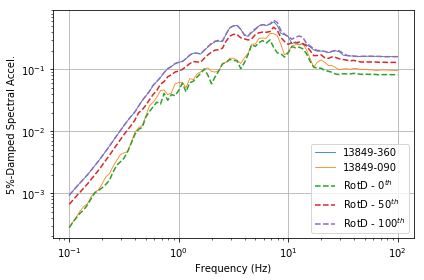

In [10]:
fig, ax = plt.subplots()

for ts in time_series:
    ax.plot(osc_freqs, ts['spec_accels'], linewidth=0.8, label=ts['name'])

for percentile in np.unique(rotated_resp.percentile):
    selected = rotated_resp[rotated_resp.percentile == percentile]
    ax.plot(selected.osc_freq, selected.spec_accel, 
            linestyle='--', label='RotD - %d$^{th}$' % percentile)
    
ax.set(
    xlabel='Frequency (Hz)', xscale='log', alpha=0.8,
    ylabel='5%-Damped Spectral Accel.', yscale='log',
)
ax.legend()
ax.grid()
fig.tight_layout()

The $0^{th}$ and $100^{th}$ percentiles are associated with an angle relative to the first time series. The other percentiles do not have an associated angles

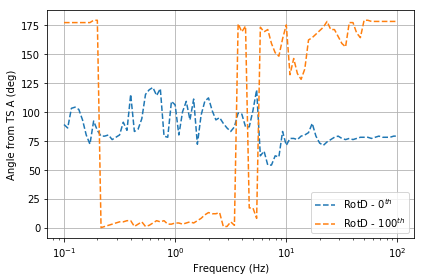

In [11]:
fig, ax = plt.subplots()

for percentile in [0, 100]:
    selected = rotated_resp[rotated_resp.percentile == percentile]
    ax.plot(selected.osc_freq, selected.angle, 
            linestyle='--', label='RotD - %d$^{th}$' % percentile)
    
ax.set(
    xlabel='Frequency (Hz)', xscale='log', alpha=0.8,
    ylabel='Angle from TS A (deg)',
)
ax.legend()
ax.grid()
fig.tight_layout()